# Compute and plot the bottom-500m-averaged stratification from WOA18

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from gsw import Nsquared, p_from_z, z_from_p
  
import warnings
warnings.filterwarnings('ignore')

## Load the WOA18 climatological T and S

In [2]:
woa18_t00 = xr.open_dataset('/g/data/nm03/lxy581/WOA18/0_woa18_decav_t00_04.nc',drop_variables='time')
woa18_s00 = xr.open_dataset('/g/data/nm03/lxy581/WOA18/0_woa18_decav_s00_04.nc',drop_variables='time')

lon = woa18_t00.lon
lat = woa18_t00.lat
dep = woa18_t00.depth

t_an = woa18_t00.t_an.squeeze()
s_an = woa18_s00.s_an.squeeze()

nx = lon.size
ny = lat.size
nz = dep.size

## Compute the 3D stratification

In [3]:
pres = (p_from_z(-woa18_t00.depth,woa18_t00.lat))
pres = pres.expand_dims({"lon": nx}); pres['lon'] = np.array(woa18_t00.lon)
pres = pres.transpose("depth", "lat", "lon") 
N2_3D, p_mid = Nsquared(s_an,t_an,pres)
N_3D = np.sqrt(N2_3D)

## Create a mask for the bottom 500m

Convert dep from xarray to numpy array, compute the dep_mid, and convert it back to xarray

In [4]:
dep_np = np.array(dep)
dep_mid_np = (dep_np[:-1] + dep_np[1:])/2

In [5]:
lat_expand = lat.expand_dims({"depth":nz-1, "lon": nx});
lat_expand['depth'] = dep_mid_np
lat_expand['lon'] = np.array(woa18_t00.lon)
lat_expand = lat_expand.transpose("depth", "lat", "lon") 

In [6]:
depth_mid = -z_from_p(p_mid,lat_expand)

In [7]:
depth_array    = t_an * 0 + woa18_t00.depth
max_depth      = depth_array.max(dim='depth', skipna=True)
depth_mask_top = depth_mid.where(depth_mid>=max_depth-500)
depth_mask_bot = depth_mid.where(depth_mid<max_depth)
depth_mask_b5  = depth_mask_top * 0 + depth_mask_bot * 0 + 1
# depth_mask_b5[:,100,100]

## Compute and plot the bottom-500m-averaged N

In [8]:
N_3D_b5     = N_3D * depth_mask_b5
N_3D_b5_ave = N_3D_b5.mean(dim='depth',skipna=True)/(2*np.pi)

In [9]:
land = xr.where(np.isnan(t_an[0,:,:].rename('land')), 1, np.nan)

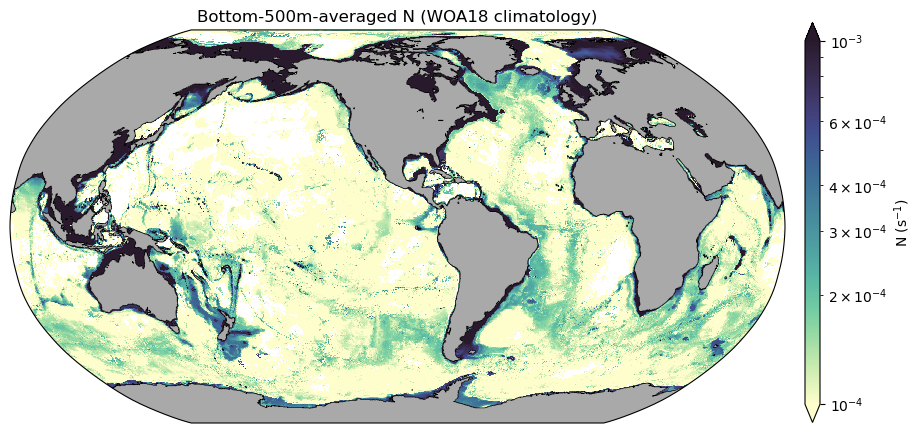

In [10]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Add model land mask
land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
# Add model coastline
land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

p1 = ax1.pcolormesh(lon, lat, N_3D_b5_ave, transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=1e-4, vmax=1e-3))
plt.title('Bottom-500m-averaged N (WOA18 climatology)')

ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
cb1.ax.set_ylabel('N (s$^{-1}$)');